<a href="https://colab.research.google.com/github/alykhaled/Image-Segmentation-using-PyTorch/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=b9273be0e31f1ec369aa96d89ebc439af51dabaa650f9719a8bf73e8d4d5ffca
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=e3f0f86412ea711dc0bd432026030

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (3/3), done.


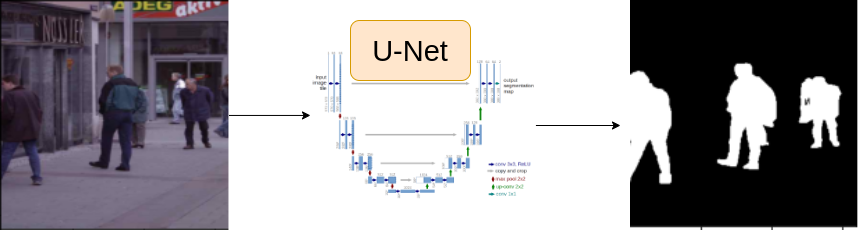

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[100]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255.0

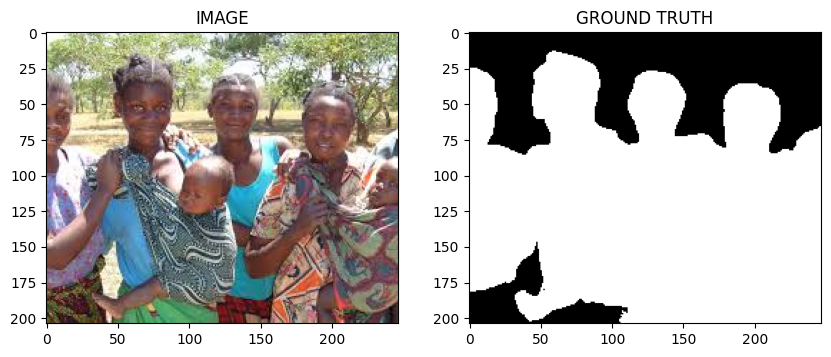

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df,valid_df = train_test_split(df,test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ],is_check_shapes=False)


# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask,axis = -1)

    if self.augmentations:
      data = self.augmentations(image=image,mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image,mask



In [14]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_train_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


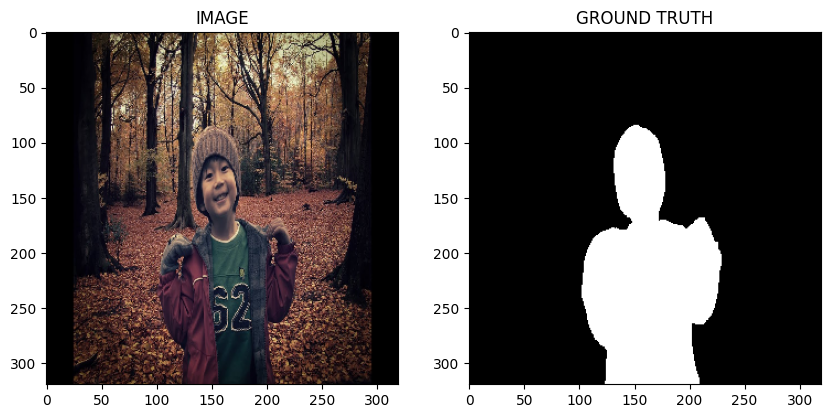

In [16]:
idx = 21
image,mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE, shuffle=True)

In [19]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image,mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights= WEIGHTS,
        in_channels= 3,
        classes = 1,
        activation=None
    )

  def forward(self,images,masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2

    return logits


In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 17.5MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [30]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss = loss.item()

  return total_loss / len(data_loader)


In [32]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits,loss = model(images,masks)
      total_loss = loss.item()

  return total_loss / len(data_loader)


# Task 8 : Train Model

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [33]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(trainloader,model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


SAVED MODEL
Epoch : 1 Train_loss : 0.02816018263498942 Valid_loss : 0.03036299745241801


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


SAVED MODEL
Epoch : 2 Train_loss : 0.013332875569661458 Valid_loss : 0.02544391353925069


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


SAVED MODEL
Epoch : 3 Train_loss : 0.011291412512461345 Valid_loss : 0.023137331008911133


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


SAVED MODEL
Epoch : 4 Train_loss : 0.020079723993937173 Valid_loss : 0.01439303457736969


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


Epoch : 5 Train_loss : 0.010607966780662536 Valid_loss : 0.02649332086245219


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


SAVED MODEL
Epoch : 6 Train_loss : 0.01014273464679718 Valid_loss : 0.008378320932388305


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


Epoch : 7 Train_loss : 0.03155377705891927 Valid_loss : 0.018648101886113485


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


Epoch : 8 Train_loss : 0.007365713516871135 Valid_loss : 0.009312528371810912


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch : 9 Train_loss : 0.009891043106714884 Valid_loss : 0.013696537415186564


100%|██████████| 15/15 [00:02<00:00,  5.10it/s]


SAVED MODEL
Epoch : 10 Train_loss : 0.012786153952280681 Valid_loss : 0.008130233983198802


100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


Epoch : 11 Train_loss : 0.009295624494552613 Valid_loss : 0.008503350615501403


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


SAVED MODEL
Epoch : 12 Train_loss : 0.007267478108406067 Valid_loss : 0.006988549729188284


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


SAVED MODEL
Epoch : 13 Train_loss : 0.007056209444999695 Valid_loss : 0.006254738569259644


100%|██████████| 15/15 [00:04<00:00,  3.03it/s]


Epoch : 14 Train_loss : 0.023417633771896363 Valid_loss : 0.010066131750742594


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Epoch : 15 Train_loss : 0.01248738169670105 Valid_loss : 0.007473895947138469


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Epoch : 16 Train_loss : 0.009260628620783489 Valid_loss : 0.008543916543324788


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


SAVED MODEL
Epoch : 17 Train_loss : 0.0071353947122891745 Valid_loss : 0.005132618049780528


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


Epoch : 18 Train_loss : 0.005610846479733785 Valid_loss : 0.0060234636068344114


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch : 19 Train_loss : 0.01420881152153015 Valid_loss : 0.006889029343922933


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


SAVED MODEL
Epoch : 20 Train_loss : 0.006103981534639994 Valid_loss : 0.004883206884066264


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Epoch : 21 Train_loss : 0.005411863327026367 Valid_loss : 0.00546251634756724


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


SAVED MODEL
Epoch : 22 Train_loss : 0.004211521148681641 Valid_loss : 0.0041214828689893086


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Epoch : 23 Train_loss : 0.00486732671658198 Valid_loss : 0.006823308269182841


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


SAVED MODEL
Epoch : 24 Train_loss : 0.006701054175694784 Valid_loss : 0.003911573439836502


100%|██████████| 15/15 [00:02<00:00,  5.04it/s]

SAVED MODEL
Epoch : 25 Train_loss : 0.007551403840382894 Valid_loss : 0.0030665313204129535


# Task 9 : Inference

In [42]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask= (pred_mask > 0.5)*1.0

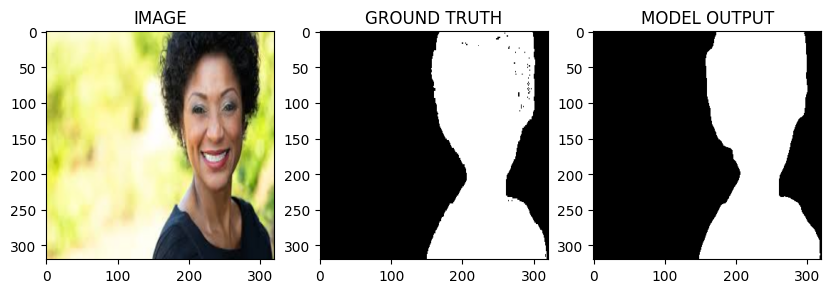

In [43]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya